# Setup

In [3]:
import sys
import os.path
import importlib.util

# insert path to the local version of spacer_tutorial package into pythonpath
if os.path.exists("src/spacer_tutorial/"):
    sys.path.append(os.path.abspath("src"))
    print("Using local versionof spacer_tutorial package")

# install z3 if needed
if importlib.util.find_spec('z3') is None:
    !{sys.executable} -m pip install z3-solver
# install spacer_tutorial if needed
if importlib.util.find_spec('spacer_tutorial') is None:
    !{sys.executable} -m pip install spacer-tutorial

Using local versionof spacer_tutorial package


In [4]:
import sys
import z3
from spacer_tutorial import *

# proof mode must be enabled before any expressions are created
z3.set_param(proof=True)
z3.set_param(model=True)
# print expressions with HTML
z3.set_html_mode(True)

In [5]:
def vc_gen(T):
    '''Verification Condition (VC) for an Inductive Invariant'''
    Inv = z3.Function('Inv', *(T.sig() + [z3.BoolSort()]))

    InvPre = Inv(*T.pre_vars())
    InvPost = Inv(*T.post_vars())
    print ('pres', T.pre_vars())
    print ('post', T.post_vars())
    print ('inputs', T.inputs())

    all_vars = T.all()
    vc_init = z3.ForAll(all_vars, z3.Implies(T.Init, InvPre))
    vc_ind = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Tr), InvPost))
    vc_bad = z3.ForAll(all_vars, z3.Implies(z3.And(InvPre, T.Bad), z3.BoolVal(False)))
    return [vc_init, vc_ind, vc_bad], InvPre

# Challenge 1

In [27]:
# def mk_ts_challenge_1(safe=True):
#     T = Ts('Ts0')
#     x, x_out = T.add_var(z3.IntSort(), name='x')
#     y, y_out = T.add_var(z3.IntSort(), name='y')
#     T.Init = z3.And(x == 0, y == 5000)
#     T.Tr = z3.And(x < y, x_out == x + 1, y_out == z3.If(x >= 5000, y + 1, y))
#     # T.Tr = z3.And(z3.Or((y - x) >= 1), x_out == x + 1, y_out == z3.If(x >= 5000, y + 1, y))
#     if safe:
#         T.Bad = z3.And(x == 10000, z3.Not(x == y))
#         # T.Bad = z3.And(z3.Not(x == y))
#     else:
#         T.Bad = z3.Not(z3.And(x == 10000, z3.Not(x == y)))
#     return T
def mk_ts_challenge_1(safe=True):
    T = Ts('Ts0')
    N = 5000
    M = N * 2
    x, x_out = T.add_var(z3.IntSort(), name='x')
    y, y_out = T.add_var(z3.IntSort(), name='y')
    T.Init = z3.And(x == 0, y == N)
    T.Tr = z3.And(z3.Or(x >= N, x < y), z3.Or(x < N, x == y), x_out == x + 1, y_out == z3.If(x >= N, y + 1, y))
    if safe:
        T.Bad = z3.And(x == M, z3.Not(y == x))
    else:
        T.Bad = z3.Not(z3.And(x == M, z3.Not(y == x)))
    return T

## safe


In [28]:
ts_challenge_1 = mk_ts_challenge_1(safe=True)
HtmlStr(ts_challenge_1)
vc_challenge_1, inv_challenge_1 = vc_gen(ts_challenge_1)
chc_to_str(vc_challenge_1)

pres [x, y]
post [x', y']
inputs []


"&forall;x, y, x', y' : x = 0 &and; y = 5000 &rArr; Inv(x, y) <br/><br/>&forall;x, y, x', y' :<br/> Inv(x, y) &and;<br/> (x &ge; 5000 &or; x &lt; y) &and;<br/> (x &lt; 5000 &or; x = y) &and;<br/> x' = x + 1 &and;<br/> y' = If(x &ge; 5000, y + 1, y) &rArr;<br/> Inv(x', y') <br/><br/>&forall;x, y, x', y' : Inv(x, y) &and; x = 10000 &and; &not;(y = x) &rArr; False <br/><br/>"

In [29]:
res_challenge_1, answer_challenge_1 = solve_horn(vc_challenge_1, max_unfold=40)
print (res_challenge_1)
push_not(answer_challenge_1.eval(inv_challenge_1))

<b>sat</b>


(10000 &ge; x &rArr; 10000 &ge; y) &and; (9999 &ge; y &rArr; 9999 &ge; x)

In [30]:
# solver = z3.solve(res_challenge_1)
# z3.solve(answer_challenge_1.eval(inv_challenge_1))
answer_challenge_1.eval(inv_challenge_1)

(&not;(x &le; 10000) &or; &not;(y &ge; 10001)) &and; (&not;(y &le; 9999) &or; &not;(x &ge; 10000))

5000 ≥ y ∧ 9998 ≥ x
(9999 ≥ y ⇒ 9999 ≥ x) ∧ 5000 ≥ y
9998 ≥ x ∧ 5000 ≥ y

## unsafe

In [9]:
ts_challenge_1_unsafe = mk_ts_challenge_1(safe=False)
HtmlStr(ts_challenge_1_unsafe)

"Transition System: Ts0<br/>\tInit: x = 0 &and; y = 5000<br/>\tBad: &not;(x = 10000 &and; &not;(y = x))<br/>\tTr: (x &ge; 5000 &or; x &lt; y) &and;<br/>(x &lt; 5000 &or; x = y) &and;<br/>x' = x + 1 &and;<br/>y' = If(x &ge; 5000, y + 1, y)"

In [10]:
vc, inv = vc_gen(ts_challenge_1_unsafe)
res, answer = solve_horn(vc)
HtmlStr(res)

pres [x, y]
post [x', y']
inputs []


'<b>unsat</b>'

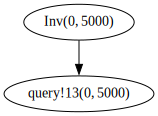

In [11]:
sp = SpacerProof(answer)
sp

# Challenge 2

In [12]:
def mk_ts_challenge_2(safe=True):
    T = Ts('Ts0')
    x, x_out = T.add_var(z3.IntSort(), name='x')
    y, y_out = T.add_var(z3.IntSort(), name='y')
    T.Init = z3.And(x == 0, y == 0)
    T.Tr = z3.And(x >= 0 , y >= 0, z3.Or((x % 2) == 0, x == (y + y)), z3.Or((x % 2) == 1, x == (1 + y + y)), x_out == x + 1, y_out == z3.If((x % 2) == 0, y + 1, y))
    if safe:
        T.Bad = z3.And(x == 2 * 1351235, z3.Not(y == 1351235))
    else:
        T.Bad = z3.Not(z3.And(x == 2 * 1351235, z3.Not(y == 1351235)))
    return T

## safe


In [13]:
ts_challenge_2 = mk_ts_challenge_2(safe=True)
HtmlStr(ts_challenge_2)
vc_challenge_2, inv_challenge_2 = vc_gen(ts_challenge_2)
chc_to_str(vc_challenge_2)

pres [x, y]
post [x', y']
inputs []


"&forall;x, y, x', y' : x = 0 &and; y = 0 &rArr; Inv(x, y) <br/><br/>&forall;x, y, x', y' :<br/> Inv(x, y) &and;<br/> x &ge; 0 &and;<br/> y &ge; 0 &and;<br/> (x%2 = 0 &or; x = y + y) &and;<br/> (x%2 = 1 &or; x = 1 + y + y) &and;<br/> x' = x + 1 &and;<br/> y' = If(x%2 = 0, y + 1, y) &rArr;<br/> Inv(x', y') <br/><br/>&forall;x, y, x', y' :<br/> Inv(x, y) &and; x = 2702470 &and; &not;(y = 1351235) &rArr; False <br/><br/>"

In [14]:
res_challenge_2, answer_challenge_2 = solve_horn(vc_challenge_2)
print (res_challenge_2)
push_not(answer_challenge_2.eval(inv_challenge_2))

<b>sat</b>


(2702470 &ge; x &rArr; 1351235 &ge; y) &and; (1351234 &ge; y &rArr; 2702469 &ge; x)

## unsafe


In [15]:
ts_challenge_2_unsafe = mk_ts_challenge_2(safe=False)
HtmlStr(ts_challenge_2_unsafe)

"Transition System: Ts0<br/>\tInit: x = 0 &and; y = 0<br/>\tBad: &not;(x = 2702470 &and; &not;(y = 1351235))<br/>\tTr: x &ge; 0 &and;<br/>y &ge; 0 &and;<br/>(x%2 = 0 &or; x = y + y) &and;<br/>(x%2 = 1 &or; x = 1 + y + y) &and;<br/>x' = x + 1 &and;<br/>y' = If(x%2 = 0, y + 1, y)"

In [16]:
vc, inv = vc_gen(ts_challenge_1_unsafe)
res, answer = solve_horn(vc)
HtmlStr(res)

pres [x, y]
post [x', y']
inputs []


'<b>unsat</b>'

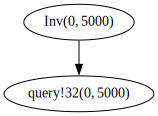

In [17]:
sp = SpacerProof(answer)
sp